In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from src.ml import RegressorFramework
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.metrics import r2_score, root_mean_squared_error

In [2]:
asv_path = "./data/ASVs.csv"
amino_acid_path = "./data/AAs.csv"
fp_path = "./data/FPs.csv"
asv = pd.read_csv(asv_path, index_col=0)
amino_acid = pd.read_csv(amino_acid_path, index_col=0)
fp = pd.read_csv(fp_path, index_col=0)

In [3]:
bagging_param_grid = {'n_estimators': [50, 80, 100]}
random_forest_param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [None, 4, 5, 6]}
extra_trees_param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [None, 4, 5, 6]}
adaboost_param_grid = {'n_estimators': [50, 80, 100], 'learning_rate': [0.1, 0.3, 0.5]}
xgboost_param_grid = {'n_estimators': [50, 80, 100], 'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [3, 4, 5]}
param_grids = {
    "Bagging": bagging_param_grid,
    "Random Forest": random_forest_param_grid,
    "Extra Trees": extra_trees_param_grid,
    "AdaBoost": adaboost_param_grid,
    "XGBoost": xgboost_param_grid,
}

In [4]:
models = {
    "Bagging": BaggingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
}

In [5]:
target_asv = ['B_ASV_15625', 'B_ASV_95119', 'B_ASV_143173', 'B_ASV_48893', 'B_ASV_131779', 'B_ASV_125122']
asv = asv.loc[:, asv.columns.isin(target_asv)]
fp = fp[['Moisture', 'TA']]
X = pd.concat([asv, fp], axis=1)

In [6]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

In [7]:
results = []
best_models = {}
predictions_record = []

for aa in amino_acid.columns:
    y = amino_acid[aa]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    best_r2 = -float('inf')
    best_model = None
    best_model_name = None
    best_rmse = None
    best_params = None
    best_preds = None
    best_y_true = None

    for name, model in models.items():
        param_grid = param_grids.get(name, {})
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        tuned_model = grid_search.best_estimator_
        reg = RegressorFramework(tuned_model)
        reg.fit(X_train, y_train)
        r2_score_val, rmse_score, preds = reg.evaluate(X_test, y_test)

        results.append({
            'model': name,
            'amino_acid': aa,
            'r2': r2_score_val,
            'rmse': rmse_score,
            'best_params': grid_search.best_params_
        })

        if r2_score_val > best_r2:
            best_r2 = r2_score_val
            best_model = tuned_model
            best_model_name = name
            best_rmse = rmse_score
            best_params = grid_search.best_params_
            best_preds = preds
            best_y_true = y_test.values

    reg = RegressorFramework(best_model)
    reg.fit(X_train, y_train)
    model_path = os.path.join(save_dir, f"{aa}_{best_model_name}_regressor.joblib")
    joblib.dump(reg, model_path)
    best_models[aa] = reg

    for true_val, pred_val in zip(best_y_true, best_preds):
        predictions_record.append({
            'amino_acid': aa,
            'model': best_model_name,
            'true_value': true_val,
            'predicted_value': pred_val
        })

results_df = pd.DataFrame(results)
best_models_df = results_df.loc[results_df.groupby('amino_acid')['r2'].idxmax()].reset_index(drop=True)
predictions_df = pd.DataFrame(predictions_record)

results_df.to_csv("./data/all_model_results.csv", index=False)
best_models_df.to_csv("./data/best_model_per_amino_acid.csv", index=False)
predictions_df.to_csv("./data/predicted_vs_true_values.csv", index=False)

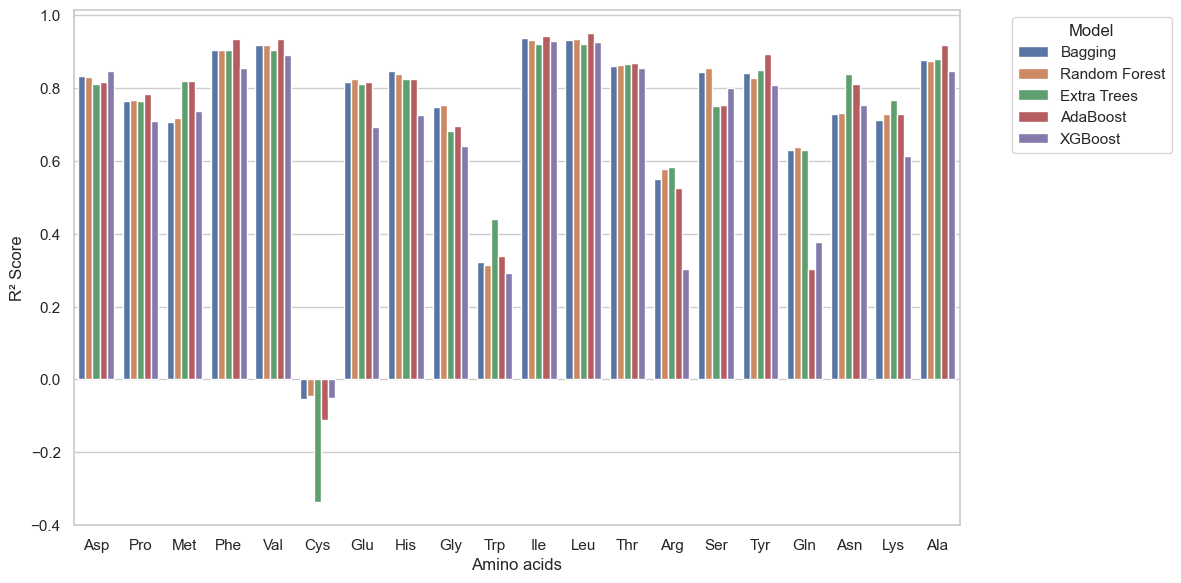

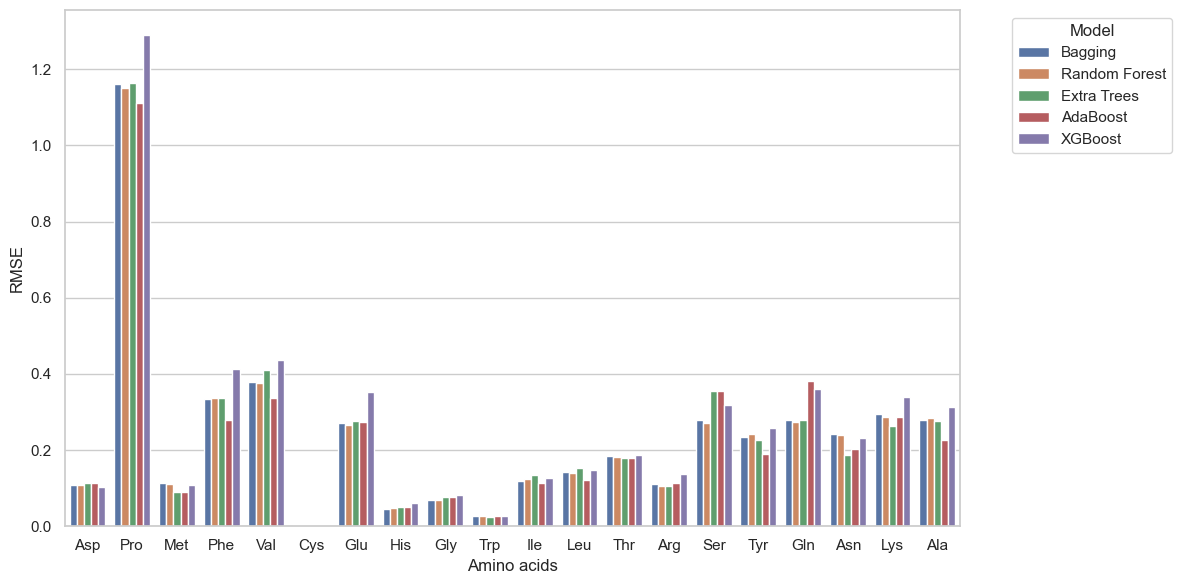

In [8]:
sns.set(style="whitegrid")

# R² plot
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='amino_acid', y='r2', hue='model', errorbar=None)
plt.xlabel("Amino acids")
plt.ylabel("R² Score")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# plt.savefig(f"Predict R2.pdf", format="pdf")

# RMSE plot
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='amino_acid', y='rmse', hue='model', errorbar=None)
plt.xlabel("Amino acids")
plt.ylabel("RMSE")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# plt.savefig(f"Predict RMSE.pdf", format="pdf")
plt.close()

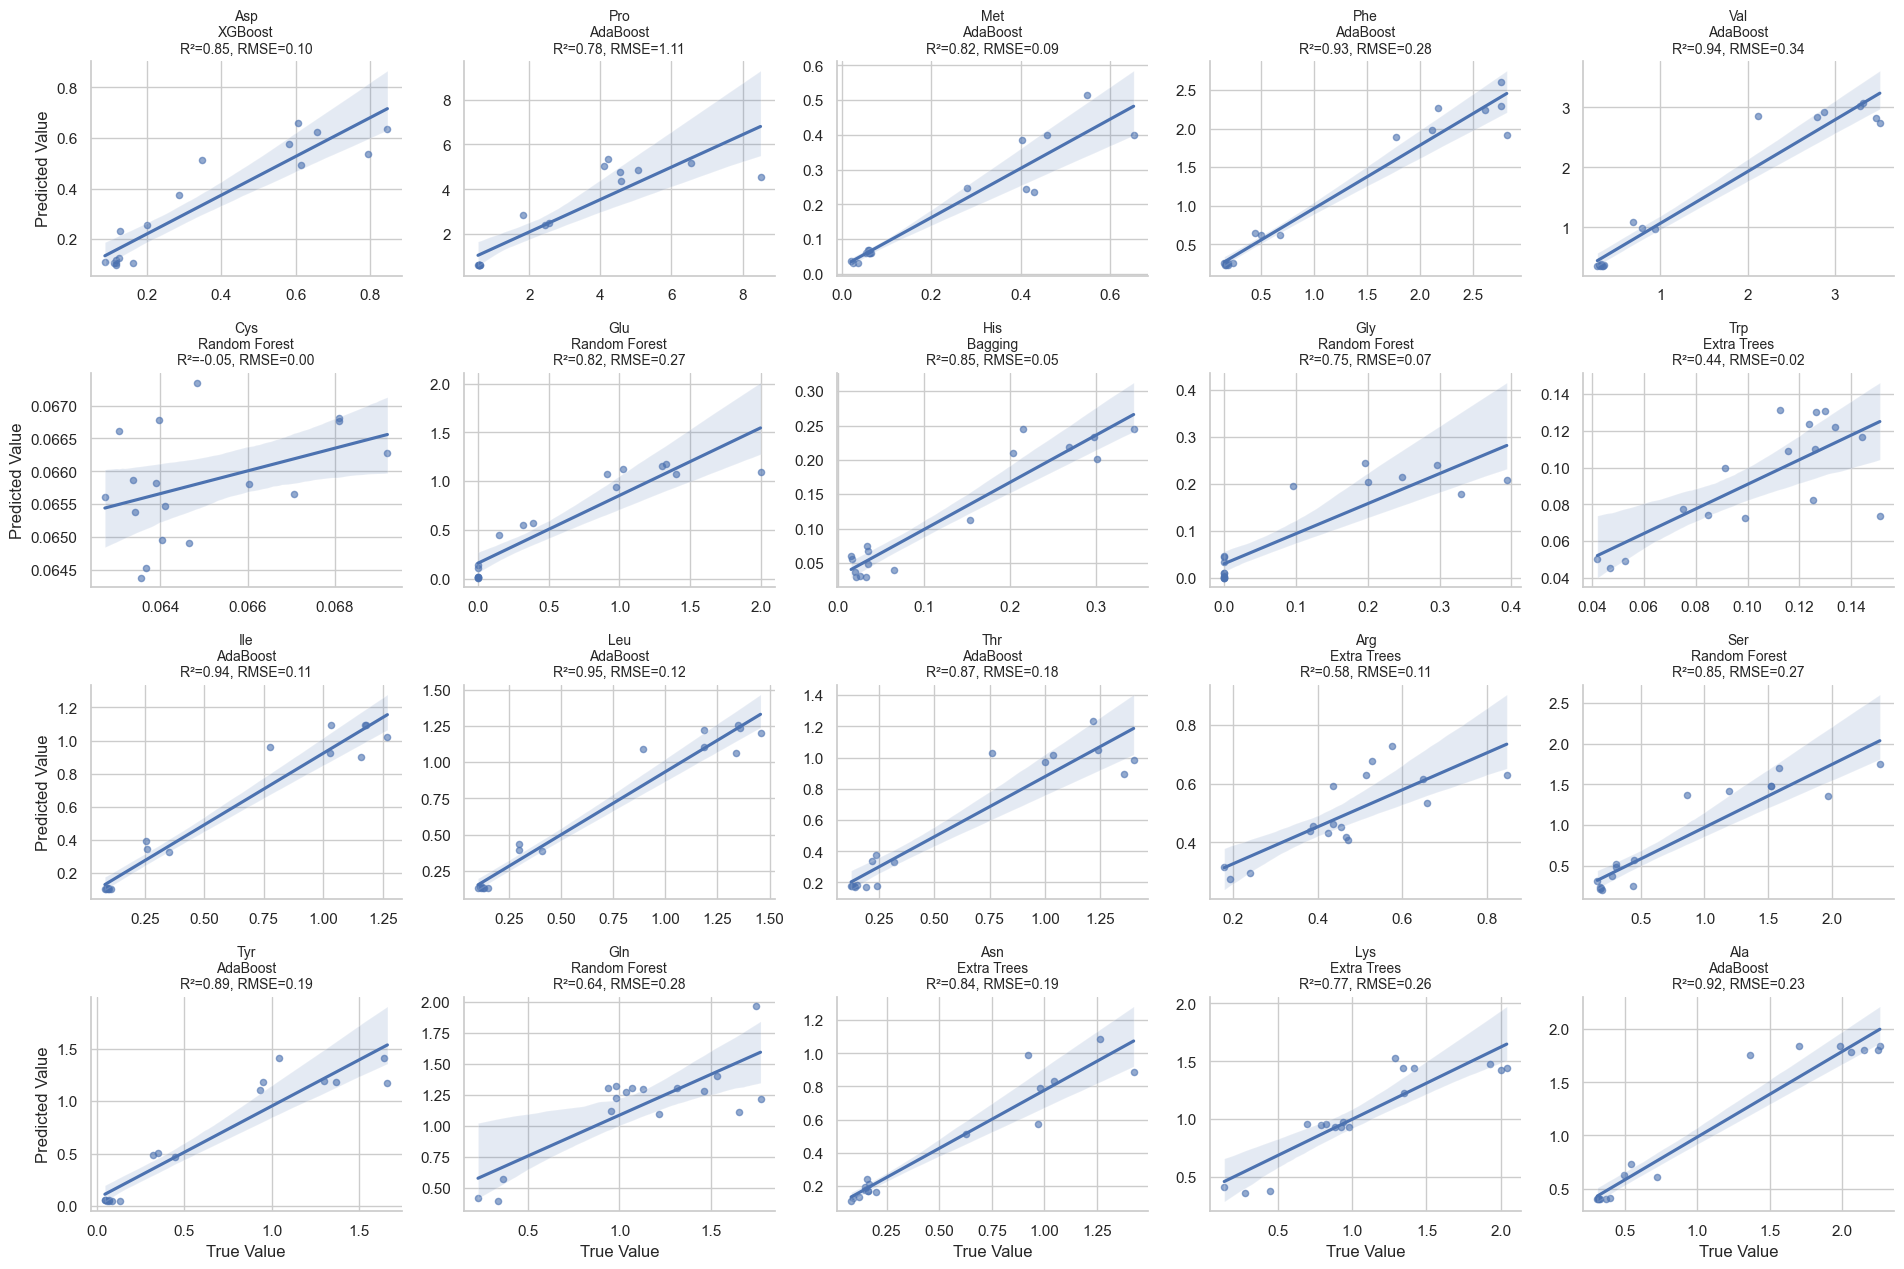

In [9]:
# 读取预测数据
df = pd.read_csv('./data/predicted_vs_true_values.csv')

# 获取每个氨基酸的最优模型（假设每个氨基酸只对应一个最优模型）
best_model_df = df.groupby('amino_acid')['model'].first().reset_index()
df = df.merge(best_model_df, on=['amino_acid', 'model'])

# 计算每个氨基酸的 R2 和 RMSE
summary_stats = df.groupby('amino_acid').apply(
    lambda group: pd.Series({
        'R2': r2_score(group['true_value'], group['predicted_value']),
        'RMSE': root_mean_squared_error(group['true_value'], group['predicted_value']),
        'model': group['model'].iloc[0]
    })
).reset_index()


df = df.merge(summary_stats[['amino_acid', 'R2', 'RMSE']], on='amino_acid', how='left')

g = sns.FacetGrid(df, col='amino_acid', col_wrap=5, height=3.2, aspect=1.2, sharex=False, sharey=False)
g.map_dataframe(sns.regplot, x='true_value', y='predicted_value', scatter_kws={'alpha': 0.6, 's': 20})


stats_dict = summary_stats.set_index('amino_acid').to_dict(orient='index')

for ax in g.axes.flatten():
    title = ax.get_title()
    if '=' in title:
        aa = title.split('=')[-1].strip()
        if aa in stats_dict:
            r2 = stats_dict[aa]['R2']
            rmse = stats_dict[aa]['RMSE']
            model_name = stats_dict[aa]['model']
            ax.set_title(f"{aa}\n{model_name}\nR²={r2:.2f}, RMSE={rmse:.2f}", fontsize=10)

# 坐标轴标签和标题
g.set_axis_labels("True Value", "Predicted Value")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
# plt.savefig("model_predict_true.pdf", format="pdf")
plt.close()

In [10]:
test_asv_path = "./data/test/test_ASVs.csv"
test_amino_acid_path = "data/test/test_AAs.csv"
test_fp_path = "./data/test/test_FPs.csv"
test_asv = pd.read_csv(test_asv_path, index_col=0)
test_amino_acid = pd.read_csv(test_amino_acid_path, index_col=0)
test_fp = pd.read_csv(test_fp_path, index_col=0)

In [11]:
test_asv = test_asv.loc[:, test_asv.columns.isin(target_asv)]
test_fp = test_fp[['Moisture', 'TA']]
X_test = pd.concat([test_asv, test_fp], axis=1)

In [12]:
test_results = []
predictions_dict = {}

for aa in test_amino_acid.columns:
    row = best_models_df[best_models_df['amino_acid'] == aa].iloc[0]
    model_name = row['model']
    model_path = os.path.join("saved_models", f"{aa}_{model_name}_regressor.joblib")

    reg = joblib.load(model_path)
    y_true = test_amino_acid[aa]
    r2, rmse, y_pred = reg.evaluate(X_test, y_true)

    test_results.append({
        'amino_acid': aa,
        'model': model_name,
        'r2': r2,
        'rmse': rmse
    })
    predictions_dict[aa] = y_pred

test_results_df = pd.DataFrame(test_results)
predictions_df = pd.DataFrame(predictions_dict, index=test_amino_acid.index)

test_results_df.to_csv("./data/test_results_metrics.csv", index=False)
predictions_df.to_csv("./data/test_predictions.csv")
test_results_df

,amino_acid,model,r2,rmse
0,Asp,XGBoost,0.423028,0.159451
1,Pro,AdaBoost,0.709095,0.871072
2,Met,AdaBoost,0.684887,0.119586
3,Phe,AdaBoost,0.740101,0.413754
4,Val,AdaBoost,0.816508,0.458723
5,Cys,Random Forest,0.259634,0.001162
6,Glu,Random Forest,0.320884,0.571961
7,His,Bagging,0.846767,0.040039
8,Gly,Random Forest,0.825304,0.049670
9,Trp,Extra Trees,-0.010311,0.057190
